In [2]:
import torch
print("GPU Available:", torch.cuda.is_available())

GPU Available: False


In [1]:
!pip install snntorch


In [7]:
import pickle
import snntorch as snn
import snntorch.spikeplot as splt
import snntorch.spikegen as spk
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import time

dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Working with dataset5_Tau**

In [2]:
np.random.seed(42)

#load dataset
with open("/content/drive/MyDrive/Colab Notebooks/SNN/Dataset/dataset5_Tau.pkl", "rb") as f:
    data = pickle.load(f)

#split data into test and train
indexes = np.random.permutation(len(data))
train_size = int(0.8 * len(data))
train_indexes = indexes[:train_size]
test_indexes = indexes[train_size:]

train_data = [data[i] for i in train_indexes]
test_data = [data[i] for i in test_indexes]

print(f"training data size {len(train_data)}")
print(f"test data size {len(test_data)}")


#create CustomDataset
class CustomDataset(Dataset):
    def __init__(self, data):
        self.y = []
        self.x = []
        self.labels = []
        self.tau = []

        #process each sample
        for sample in data:
            y = sample[0]
            x = sample[1]
            label = sample[2]
            tau = sample[3]

            self.y.append(y)
            self.x.append(x)
            self.labels.append(label)
            self.tau.append(tau)

        self.y = torch.tensor(self.y, dtype = torch.float32)
        self.x = torch.tensor(self.x, dtype= torch.float32)
        self.labels = torch.tensor(self.labels, dtype= torch.long)
        self.tau = torch.tensor(self.tau, dtype= torch.float32)

    def __len__(self):
        return(len(self.x))

    def __getitem__(self, index):
        return self.y[index], self.x[index], self.labels[index], self.tau[index]

#create train and test dataset
train_dataset = CustomDataset(train_data)
test_dataset = CustomDataset(test_data)

#create dataloader
train_loader = DataLoader(train_dataset, batch_size=128 , shuffle=True, drop_last= True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle= True, drop_last= True)


import pandas as pd
print("Class distribution in the original training dataset:", pd.Series(train_dataset.labels).value_counts())
print("Class distribution in the original testing dataset:", pd.Series(test_dataset.labels).value_counts())

for y, x, v, tau in train_loader:
    print(f"Batch y shape: {y.shape}")
    print(f"Batch x shape: {x.shape}")
    print(f"Batch labels shape: {v.shape}")
    print(f"Batch tau shape: {tau.shape}")
    break

    break  # Just check the first batch


training data size 80000
test data size 20000


<ipython-input-2-35b519b87fca>:40: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  self.y = torch.tensor(self.y, dtype = torch.float32)


Class distribution in the original training dataset: 0    40132
1    39868
Name: count, dtype: int64
Class distribution in the original testing dataset: 1    10064
0     9936
Name: count, dtype: int64
Batch y shape: torch.Size([128, 80, 16])
Batch x shape: torch.Size([128, 80, 16])
Batch labels shape: torch.Size([128])
Batch tau shape: torch.Size([128])


In [ ]:
import torch

# Compute mean and standard deviation of your dataset
x_mean = train_dataset.x.mean(dim=0)
x_std = train_dataset.x.std(dim=0)

y_mean = train_dataset.y.mean(dim=0)
y_std = train_dataset.y.std(dim=0)

# print(f"{x_mean.shape}, X Mean: {x_mean}")
# print(f"{x_std.shape}X Std Dev: {x_std}")
# print(f"{y_mean.shape}Y Mean: {y_mean}")
# print(f"{y_std.shape}Y Std Dev: {y_std}")


In [3]:
from snntorch import surrogate

#layer parameters
Ny=32
Nx=32
num_inputs = 16
num_hidden = 256
num_output = 1
num_steps = 80
beta = 0.95
batch_size = 128
dtype = torch.float

#define network
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        spike_grad = surrogate.fast_sigmoid() # surrogate gradient function

        # initialize additional layers for y and x inputs
        self.fc_y = nn.Linear(num_inputs, Ny)
        self.lif_y = snn.Leaky(beta = beta)
        self.fc_x = nn.Linear(num_inputs, Nx)
        self.lif_x = snn.Leaky(beta = beta)

        # initialize SNN layers
        self.fc1 = nn.Linear(Ny + Nx, num_hidden)
        self.lif1 = snn.Leaky(beta = beta)

        # Classification Branch v
        self.fc2 = nn.Linear(num_hidden, num_output)
        self.lif2 = snn.Leaky(beta = beta)

        # Regression Branch τ
        beta_out = torch.rand(1) # randomly initialize decay rate for output neuron
        self.fc_reg = nn.Linear(num_hidden, num_output)
        self.li_out = snn.Leaky(beta=beta, threshold=1.0, learn_beta=True, spike_grad=spike_grad, reset_mechanism="none") #Note the reset mechanism is disabled and we will disregard output spikes.

        # No activation function for τ prediction


    def forward(self, y, x):

        # initialize hidden states at t=0
        mem_y = self.lif_y.init_leaky()
        mem_x = self.lif_x.init_leaky()
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem_reg = self.li_out.init_leaky()

        mem2_rec = []
        spk2_rec = []
        tau_rec = []

        for step in range(num_steps):                         #Loop over 80 time steps
            cur_y = self.fc_y(y[step])
            spk_y, mem_y = self.lif_y(cur_y, mem_y)
            cur_x = self.fc_x(x[step])
            spk_x, mem_x = self.lif_x(cur_x, mem_x)

            combined_input = torch.cat((spk_y, spk_x), dim=1) #Shape:[batch_size:128, Ny + Nx:64]

            cur1 = self.fc1(combined_input)
            spk1, mem1 = self.lif1(cur1, mem1)                #torch.Size([128, 256])

            # Classification branch
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)                #torch.Size([128, 1])
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

            # Regression branch
            cur_reg = self.fc_reg(spk1)
            _, mem_reg = self.li_out(cur_reg, mem_reg)
            tau_rec.append(mem_reg)

        return (torch.stack(spk2_rec, dim=0),
                torch.stack(mem2_rec, dim=0),
                torch.stack(tau_rec, dim=0)) #[num_steps:80, batch_size:128, 1]

# Load the network onto CUDA if available
net = Net().to(device)


**Add a extra hidden layer in Network structure**

In [ ]:
from snntorch import surrogate

#layer parameters
Ny=32
Nx=32
num_inputs = 16
num_hidden = 256
num_output = 1
num_steps = 80
beta = 0.95
batch_size = 128
dtype = torch.float

#define network
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        spike_grad = surrogate.fast_sigmoid() # surrogate gradient function

        # initialize additional layers for y and x inputs
        self.fc_y = nn.Linear(num_inputs, Ny)
        self.lif_y = snn.Leaky(beta = beta)
        self.fc_x = nn.Linear(num_inputs, Nx)
        self.lif_x = snn.Leaky(beta = beta)

        # initialize SNN layers
        # self.fc1 = nn.Linear(Ny + Nx, num_hidden)
        # self.lif1 = snn.Leaky(beta = beta)
        self.fc1 = nn.Linear(Ny + Nx, 512)
        self.lif1 = snn.Leaky(beta=beta)
        #------------------------------------
        self.fc12 = nn.Linear(512, num_hidden)
        self.lif12 = snn.Leaky(beta=beta)
        #------------------------------------

        # Classification Branch v
        self.fc2 = nn.Linear(num_hidden, num_output)
        self.lif2 = snn.Leaky(beta = beta)

        # Regression Branch τ
        beta_out = torch.rand(1) # randomly initialize decay rate for output neuron
        self.fc_reg = nn.Linear(num_hidden, num_output)
        self.li_out = snn.Leaky(beta=beta, threshold=1.0, learn_beta=True, spike_grad=spike_grad, reset_mechanism="none") #Note the reset mechanism is disabled and we will disregard output spikes.

        # No activation function for τ prediction


    def forward(self, y, x):

        # initialize hidden states at t=0
        mem_y = self.lif_y.init_leaky()
        mem_x = self.lif_x.init_leaky()
        mem1 = self.lif1.init_leaky()
        #------------------------------------
        mem12 = self.lif12.init_leaky()
        #------------------------------------
        mem2 = self.lif2.init_leaky()
        mem_reg = self.li_out.init_leaky()

        mem2_rec = []
        spk2_rec = []
        tau_rec = []

        for step in range(num_steps):                         #Loop over 80 time steps
            cur_y = self.fc_y(y[step])
            spk_y, mem_y = self.lif_y(cur_y, mem_y)
            cur_x = self.fc_x(x[step])
            spk_x, mem_x = self.lif_x(cur_x, mem_x)

            combined_input = torch.cat((spk_y, spk_x), dim=1) #Shape:[batch_size:128, Ny + Nx:64]

            cur1 = self.fc1(combined_input)
            spk1, mem1 = self.lif1(cur1, mem1)                #torch.Size([128, 256])
            #------------------------------------
            cur12 = self.fc12(spk1)
            spk12, mem12 = self.lif12(cur12, mem12)
            #------------------------------------

            # Classification branch
            cur2 = self.fc2(spk12) #(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)                #torch.Size([128, 1])
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

            # Regression branch
            cur_reg = self.fc_reg(spk1)
            _, mem_reg = self.li_out(cur_reg, mem_reg)
            tau_rec.append(mem_reg)

        return (torch.stack(spk2_rec, dim=0),
                torch.stack(mem2_rec, dim=0),
                torch.stack(tau_rec, dim=0)) #[num_steps:80, batch_size:128, 1]

# Load the network onto CUDA if available
net = Net().to(device)


In [4]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import torch

def calculate_metrics(y_true, y_pred_probs, threshold= num_steps / 2):
    # Convert probabilities to binary predictions
    y_pred = (y_pred_probs > threshold).float()

    # Confusion Matrix
    cm = confusion_matrix(y_true.cpu(), y_pred.cpu())
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    # Precision, Recall, F1
    precision = precision_score(y_true.cpu(), y_pred.cpu())
    recall = recall_score(y_true.cpu(), y_pred.cpu())
    f1 = f1_score(y_true.cpu(), y_pred.cpu())

    # ROC-AUC Score
    auc = roc_auc_score(y_true.cpu(), y_pred_probs.cpu())

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC-AUC Score: {auc:.4f}")

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_true.cpu(), y_pred_probs.cpu())
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()


def print_batch_accuracy(spk_pred, v_target, tau_pred, tau_target, train=False):

    # Compute Classification Accuracy
    pred = (spk_pred.sum(dim=0) > num_steps / 2).float()
    class_acc = (pred == v_target).float().mean().item()

    # Compute Regression Errors
    tau_output = tau_pred.mean(dim=0)
    tau_output = torch.mul(tau_output, v_target)
    mse = loss_reg(tau_output, tau_target).item() #torch.nn.functional.mse_loss(tau_output, tau_target).item()  # Mean Squared Error
    # mse =0

    # print(f" tau_output:{tau_output[:5]},\r\n targets_tau: {targets_tau[:5]}")
    # if train:
    #     print(f"Train Accuracy: {acc * 100:.2f}% | MAE (τ): {mae:.6f} | MSE (τ): {mse:.6f}")
    # else:
    #     print(f"Test Accuracy: {acc * 100:.2f}% | MAE (τ): {mae:.6f} | MSE (τ): {mse:.6f}")

    return class_acc, mse


Epoch 1/10

Epoch 1/10 - Evaluation Metrics_Testing:


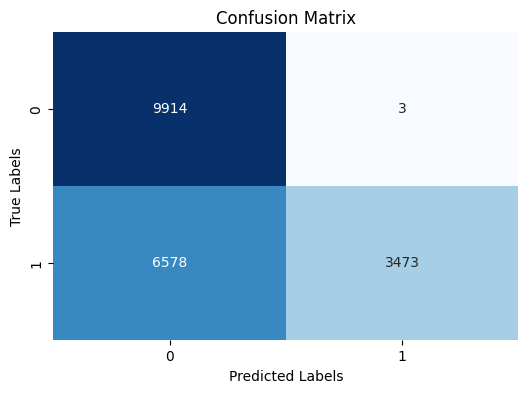

Precision: 0.9991
Recall: 0.3455
F1 Score: 0.5135
ROC-AUC Score: 0.7891


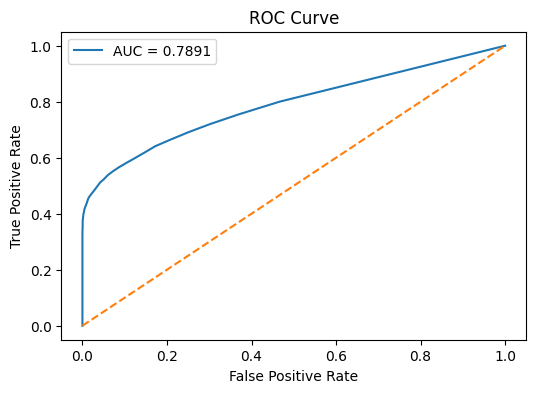

Train Loss avg: 55.3482, 
Test Loss avg: 52.5896
Train Acc: 59.36%, 
Test Acc: 67.04

MSE Train: 3.976500, 
MSE Test: 3.933859

Epoch 2/10

Epoch 2/10 - Evaluation Metrics_Testing:


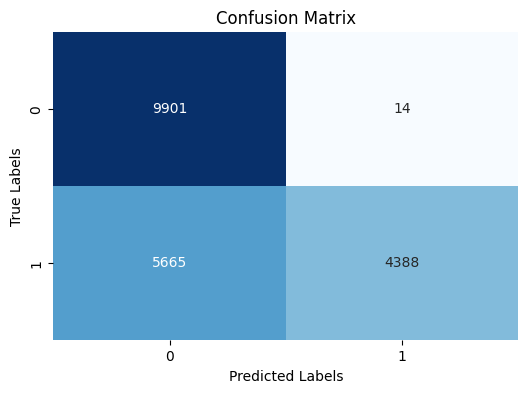

Precision: 0.9968
Recall: 0.4365
F1 Score: 0.6071
ROC-AUC Score: 0.8041


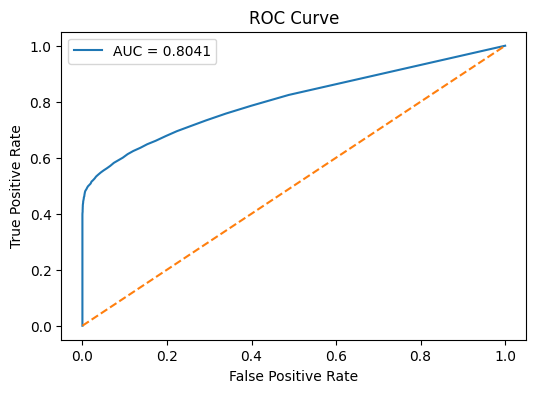

Train Loss avg: 49.0453, 
Test Loss avg: 47.7240
Train Acc: 70.62%, 
Test Acc: 71.56

MSE Train: 3.865404, 
MSE Test: 3.932257

Epoch 3/10

Epoch 3/10 - Evaluation Metrics_Testing:


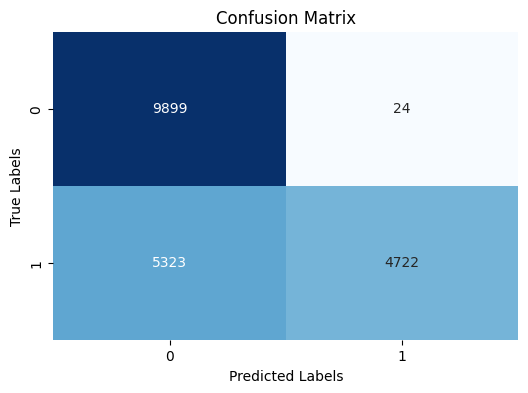

Precision: 0.9949
Recall: 0.4701
F1 Score: 0.6385
ROC-AUC Score: 0.8112


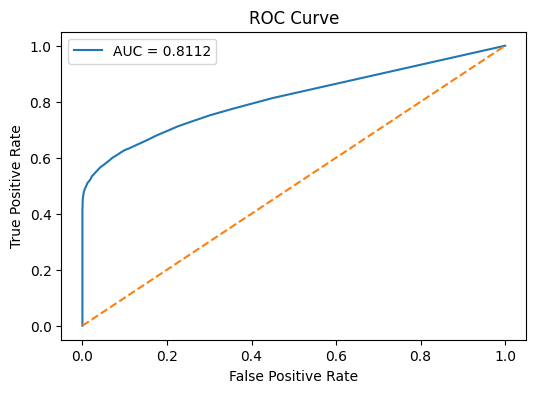

Train Loss avg: 46.4254, 
Test Loss avg: 46.5220
Train Acc: 72.70%, 
Test Acc: 73.22

MSE Train: 3.822471, 
MSE Test: 3.889788

Epoch 4/10

Epoch 4/10 - Evaluation Metrics_Testing:


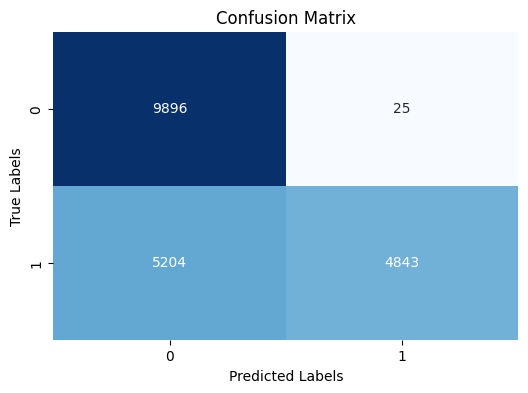

Precision: 0.9949
Recall: 0.4820
F1 Score: 0.6494
ROC-AUC Score: 0.8118


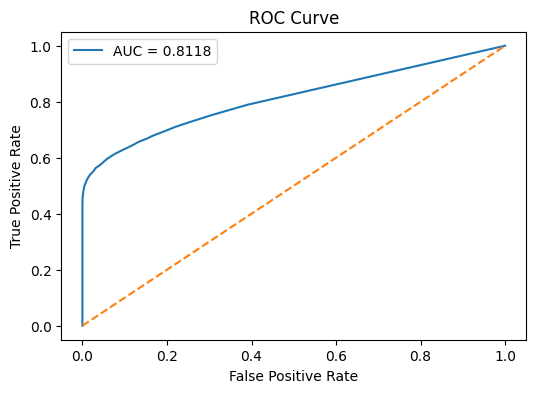

Train Loss avg: 45.6481, 
Test Loss avg: 45.9853
Train Acc: 74.00%, 
Test Acc: 73.81

MSE Train: 3.804387, 
MSE Test: 3.803760

Epoch 5/10

Epoch 5/10 - Evaluation Metrics_Testing:


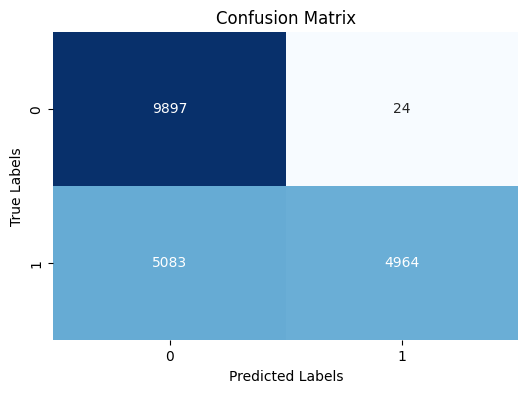

Precision: 0.9952
Recall: 0.4941
F1 Score: 0.6603
ROC-AUC Score: 0.8132


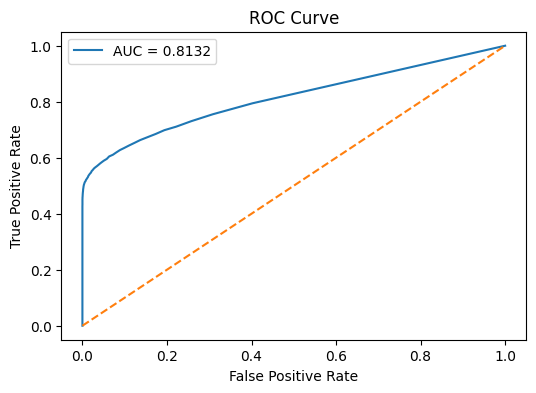

Train Loss avg: 45.0415, 
Test Loss avg: 44.8124
Train Acc: 74.70%, 
Test Acc: 74.42

MSE Train: 3.771154, 
MSE Test: 3.806310

Epoch 6/10

Epoch 6/10 - Evaluation Metrics_Testing:


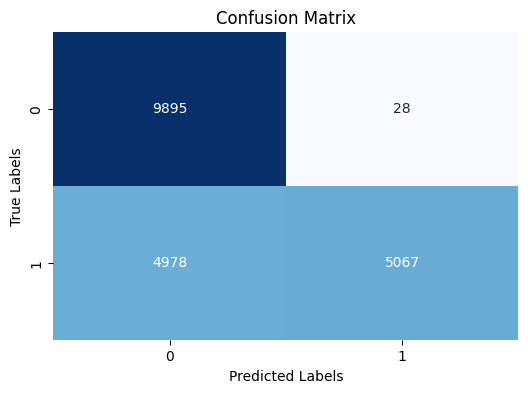

Precision: 0.9945
Recall: 0.5044
F1 Score: 0.6694
ROC-AUC Score: 0.8131


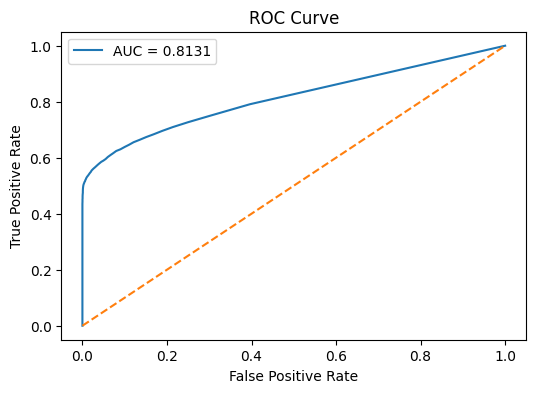

Train Loss avg: 44.3638, 
Test Loss avg: 44.0117
Train Acc: 75.00%, 
Test Acc: 74.93

MSE Train: 3.779477, 
MSE Test: 3.800496

Epoch 7/10

Epoch 7/10 - Evaluation Metrics_Testing:


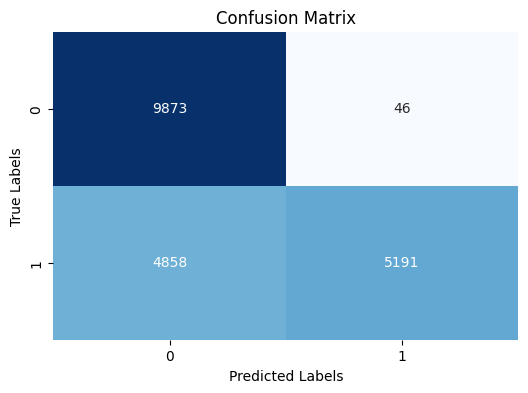

Precision: 0.9912
Recall: 0.5166
F1 Score: 0.6792
ROC-AUC Score: 0.8129


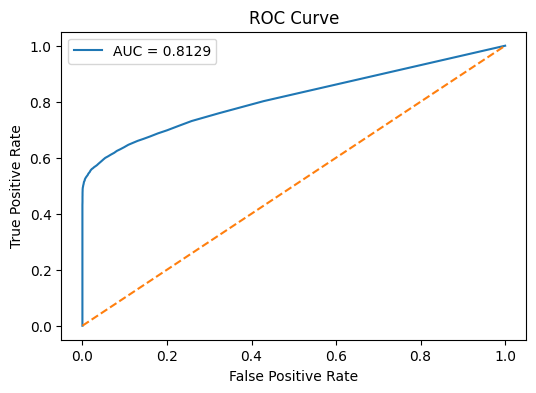

Train Loss avg: 43.7177, 
Test Loss avg: 43.9066
Train Acc: 75.31%, 
Test Acc: 75.44

MSE Train: 3.767634, 
MSE Test: 3.783738

Epoch 8/10

Epoch 8/10 - Evaluation Metrics_Testing:


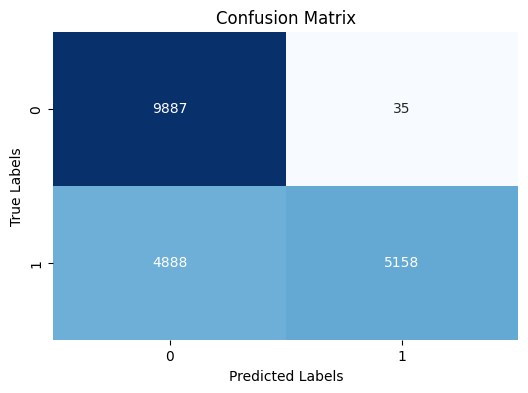

Precision: 0.9933
Recall: 0.5134
F1 Score: 0.6769
ROC-AUC Score: 0.8101


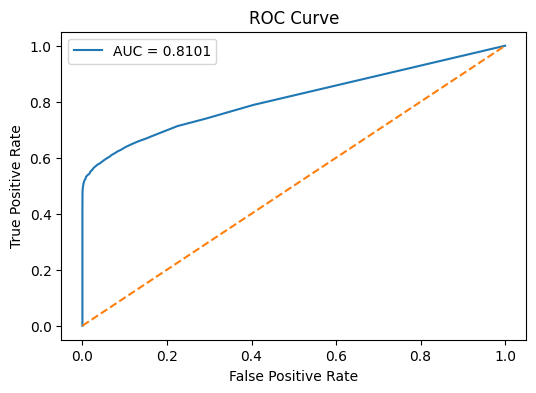

Train Loss avg: 43.5486, 
Test Loss avg: 43.8071
Train Acc: 75.65%, 
Test Acc: 75.35

MSE Train: 3.767700, 
MSE Test: 3.786379

Epoch 9/10

Epoch 9/10 - Evaluation Metrics_Testing:


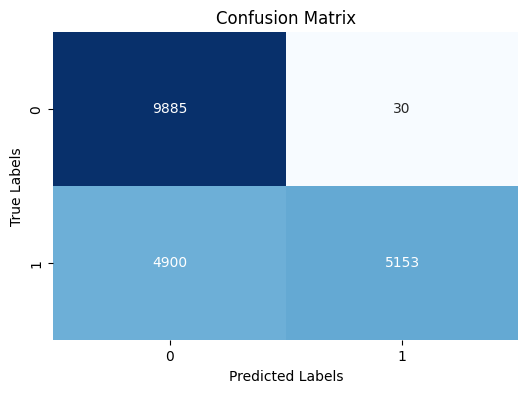

Precision: 0.9942
Recall: 0.5126
F1 Score: 0.6764
ROC-AUC Score: 0.8109


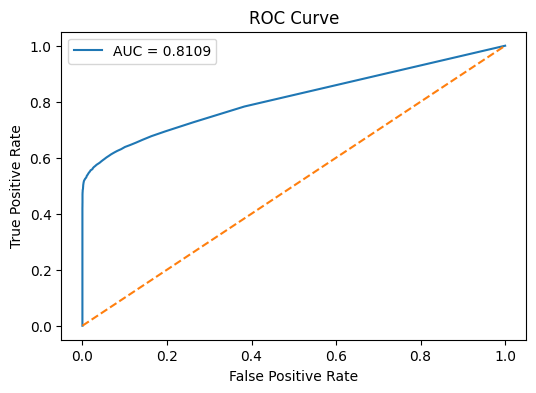

Train Loss avg: 43.3593, 
Test Loss avg: 43.5135
Train Acc: 75.83%, 
Test Acc: 75.31

MSE Train: 3.773930, 
MSE Test: 3.782949

Epoch 10/10

Epoch 10/10 - Evaluation Metrics_Testing:


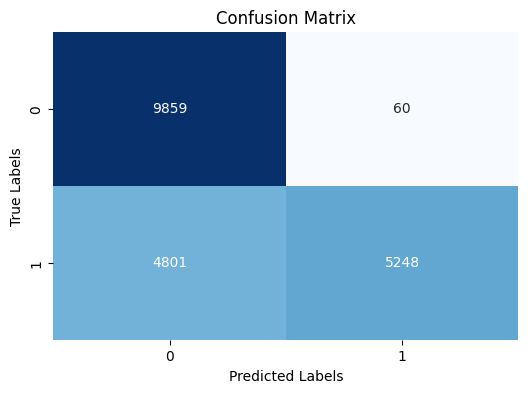

Precision: 0.9887
Recall: 0.5222
F1 Score: 0.6835
ROC-AUC Score: 0.8115


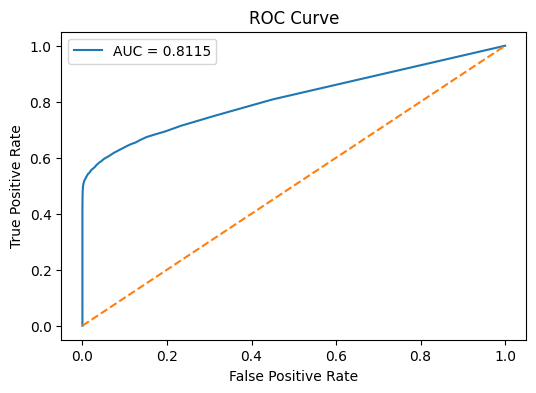

Train Loss avg: 43.3071, 
Test Loss avg: 43.7019
Train Acc: 75.93%, 
Test Acc: 75.66

MSE Train: 3.775976, 
MSE Test: 3.807228
Total time: 47.37 min.


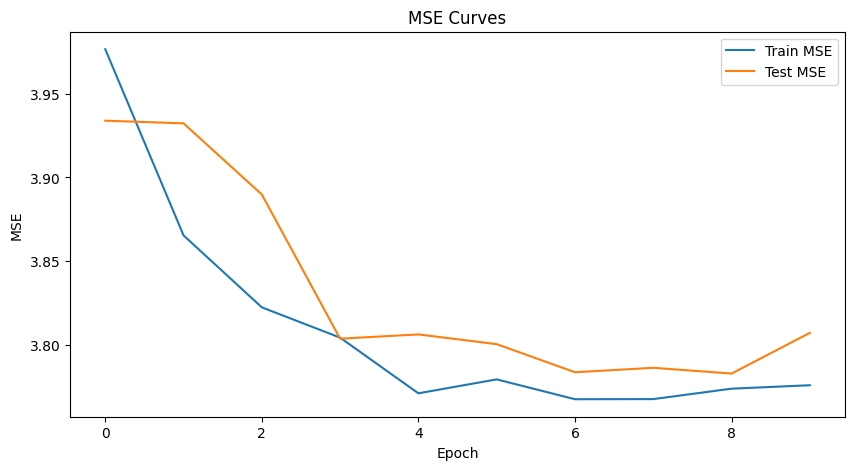

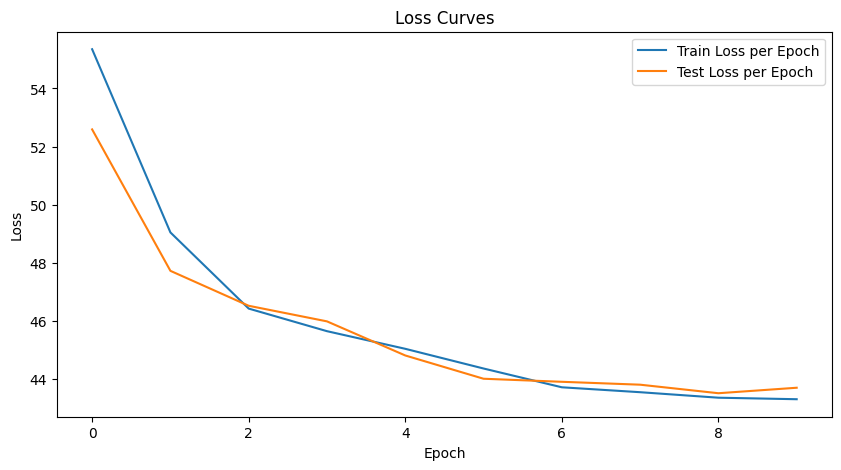

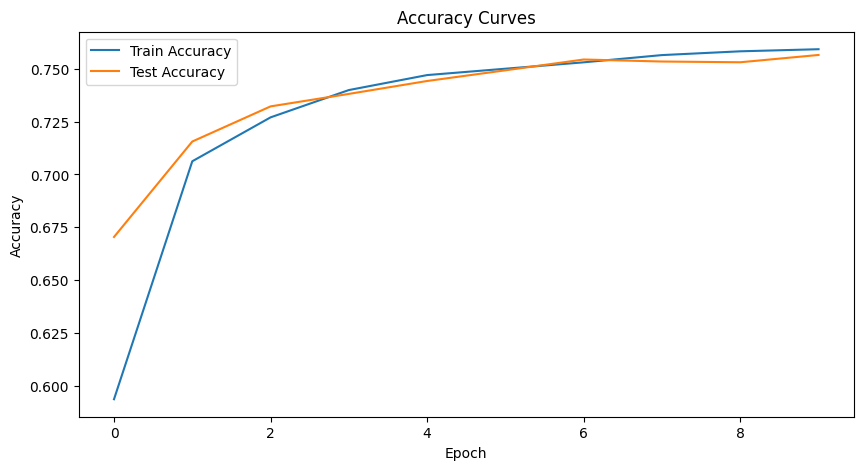

In [5]:
import time
from snntorch import functional as SF

# Loss functions
loss = nn.BCEWithLogitsLoss()
loss_reg = nn.MSELoss()

# Optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999), weight_decay=1e-4)

# Hyperparameters
tau_scale = 1e9
num_epochs = 10
num_steps = 80

epoch_train_acc = []
epoch_test_acc = []
epoch_train_loss = []
epoch_test_loss = []
epoch_train_mse = []
epoch_test_mse = []

# TRAIN--------------------------------
def train_model(train_loader):
    net.train()
    loss_hist = []
    mse_list = []
    # all_preds = []
    # all_targets = []
    train_acc_hist = []


    train_batch = iter(train_loader)
    for y, x, v, tau in train_batch:
        y = y.to(device).permute(1, 0, 2)
        x = x.to(device).permute(1, 0, 2)
        target_v = v.to(device).float().unsqueeze(1)
        target_tau = (tau.to(device) * tau_scale).float().unsqueeze(1)

        # Forward Pass
        spk_class, mem_class, tau_pre = net(y, x)  #mem_rec.shape torch.Size([80, 128, 1])

        # Classification Loss
        loss_class = torch.zeros((1), dtype=dtype, device=device)
        for step in range(num_steps):
            loss_class += loss(mem_class[step], target_v)

        # Regression Loss
        tau_output = tau_pre.mean(dim=0)
        tau_output = torch.mul(tau_output, target_v)
        loss_reg_val = loss_reg(tau_output, target_tau)

        # Total Loss
        total_loss = loss_class + loss_reg_val
        loss_hist.append(total_loss.item())

        # Backpropagation
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        # Metrics
        train_acc, mse = print_batch_accuracy(spk_class, target_v, tau_pre, target_tau, train=True)
        train_acc_hist.append(train_acc)
        mse_list.append(mse)

    avg_train_loss = sum(loss_hist) / len(loss_hist)
    avg_train_acc = sum(train_acc_hist) / len(train_acc_hist)
    avg_train_mse = sum(mse_list) / len(mse_list)

    return avg_train_loss, avg_train_acc, avg_train_mse


# TEST------------------------------------------------------
def test_model(test_loader):
    net.eval()
    test_loss_hist = []
    test_mse_list = []
    all_preds = []
    all_targets = []
    test_acc_hist = []

    with torch.no_grad():

        test_batch = iter(test_loader)
        for y, x, v, tau in test_batch:
            y = y.to(device).permute(1, 0, 2)
            x = x.to(device).permute(1, 0, 2)
            target_v = v.to(device).float().unsqueeze(1)
            target_tau = (tau.to(device) * tau_scale).float().unsqueeze(1)

            # Forward Pass
            spk_class, mem_class, tau_pre = net(y, x)

            # Classification Loss
            test_loss_class = torch.zeros((1), dtype=dtype, device=device)
            for step in range(num_steps):
                test_loss_class += loss(mem_class[step], target_v)

            # Regression Loss
            test_tau_output = tau_pre.mean(dim=0)
            test_tau_output = torch.mul(test_tau_output, target_v)
            test_loss_reg = loss_reg(test_tau_output, target_tau)
            # print(f"test_loss_reg_val: {test_loss_reg_val}")tau)

            # Total Test Loss
            test_total_loss = test_loss_class + test_loss_reg
            test_loss_hist.append(test_total_loss.item())

            # Compute Metrics
            test_acc, test_mse = print_batch_accuracy(spk_class, target_v, tau_pre, target_tau, train=False)
            test_acc_hist.append(test_acc)
            test_mse_list.append(test_mse)

            # Collect Predictions
            class_output = spk_class.sum(dim=0)
            all_preds.extend(class_output.squeeze().cpu().numpy())
            all_targets.extend(target_v.squeeze().cpu().numpy())

    # Compute Overall Test Metrics
    all_preds = torch.tensor(all_preds)
    all_targets = torch.tensor(all_targets)
    print(f"\nEpoch {epoch+1}/{num_epochs} - Evaluation Metrics_Testing:")
    calculate_metrics(all_targets, all_preds)

    avg_test_loss = sum(test_loss_hist) / len(test_loss_hist)
    avg_test_acc = sum(test_acc_hist) / len(test_acc_hist)
    avg_test_mse = sum(test_mse_list) / len(test_mse_list)

    return avg_test_loss, avg_test_acc, avg_test_mse


# MAIN TRAINING & TESTING LOOP-----------------------------

start_time = time.time()

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")

    # Train the Model
    avg_train_loss, avg_train_acc, avg_train_mse = train_model(train_loader)
    epoch_train_loss.append(avg_train_loss)
    epoch_train_acc.append(avg_train_acc)
    epoch_train_mse.append(avg_train_mse)


    # Test the Model
    avg_test_loss, avg_test_acc, avg_test_mse  = test_model(test_loader)
    epoch_test_loss.append(avg_test_loss)
    epoch_test_acc.append(avg_test_acc)
    epoch_test_mse.append(avg_test_mse)

    print(f"Train Loss avg: {avg_train_loss:.4f}, \nTest Loss avg: {avg_test_loss:.4f}")
    print(f"Train Acc: {avg_train_acc * 100:.2f}%, \nTest Acc: {avg_test_acc * 100:.2f}\n")
    print(f"MSE Train: {avg_train_mse:.6f}, \nMSE Test: {avg_test_mse:.6f}")


# Plot--------------------------------------------------------
end_time = time.time()
print(f"Total time: {(end_time - start_time) / 60:.2f} min.")

# Plot MSE Loss
plt.figure(figsize=(10, 5))
plt.plot(range(len(epoch_train_mse)), epoch_train_mse, label="Train MSE")
plt.plot(range(len(epoch_test_mse)), epoch_test_mse, label="Test MSE")
plt.title("MSE Curves")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.show()

# Plot Train & Test Loss per Epoch
plt.figure(figsize=(10, 5))
plt.plot(range(len(epoch_train_loss)), epoch_train_loss, label="Train Loss per Epoch")
plt.plot(range(len(epoch_test_loss)), epoch_test_loss, label="Test Loss per Epoch")
plt.title("Loss Curves")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plot Accuracy Curves
plt.figure(figsize=(10, 5))
plt.plot(range(len(epoch_train_acc)), epoch_train_acc, label="Train Accuracy")
plt.plot(range(len(epoch_test_acc)), epoch_test_acc, label="Test Accuracy")
plt.title("Accuracy Curves")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()




In [1]:
#Test the model with dataset5_Tau ------------------------------
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True, drop_last=False)
loss = nn.BCEWithLogitsLoss()
loss_reg = nn.MSELoss()
total = 0
correct = 0
test_loss_class=0
i=0
all_preds=[]
all_targets=[]
accList=[]
test_loss_hist=[]

with torch.no_grad():
  net.eval()
  for y_t, x_t, v, tau in test_loader:
    y_t = y_t.to(device).permute(1, 0, 2)
    x_t = x_t.to(device).permute(1, 0, 2)
    target_v = v.to(device).float().unsqueeze(1)
    target_tau = tau.to(device).float().unsqueeze(1)

    test_spk, test_mem, test_tau = net(y_t, x_t)  # forward pass

    # Calculate loss
    test_loss_class = torch.zeros((1), dtype=dtype, device=device)
    for step in range(num_steps):
      test_loss_class += loss(test_mem[step], target_v)


    # Regression Loss
    test_tau_output = test_tau.mean(dim=0)
    test_tau_output = torch.mul(test_tau_output, target_v)
    test_loss_reg = loss_reg(test_tau_output, target_tau)
    # print(f"test_loss_reg_val: {test_loss_reg_val}")tau)

    # Total Test Loss
    test_total_loss = test_loss_class + test_loss_reg
    test_loss_hist.append(test_total_loss.item())


    # Calculate accuracy
    predicted = (test_spk.sum(dim=0) > num_steps / 2).float()
    acc = (predicted == target_v).float().mean().item()
    correct += (predicted == target_v).float().sum().item()
    total += target_v.size(0)

    classOutput = test_spk.sum(dim=0)
    all_preds.extend(classOutput.squeeze().cpu().numpy())
    all_targets.extend(target_v.squeeze().cpu().numpy())

    accList.append(acc)

    i+=1
    if i == 1:
      plt.plot(predicted.cpu(), label='Predicted', color='red')
      plt.plot(target_v.cpu(), label='Target', color='green')
      plt.title('Predicted vs Target')
      plt.legend()
      plt.show()

# Compute Overall Test Metrics
all_preds = torch.tensor(all_preds)
all_targets = torch.tensor(all_targets)
calculate_metrics(all_targets, all_preds)


print(f"Total size: {total}, Correct_Prediction: {correct}")
print(f"Test Set Accuracy: {100 * correct / total}%, acc : {(sum(accList)/ len(accList)) * 100:.2f}%")
print(f"Average Test Loss: {sum(test_loss_hist) / len(test_loss_hist):.4f}")





NameError: name 'DataLoader' is not defined

**Save the model weights for dataset5**

In [ ]:
import torch

torch.save(net.state_dict(), '/content/drive/MyDrive/Colab Notebooks/SNN/Model/model_weights_dataset5.pth')


**Load the trained model**

In [ ]:
mynet = Net()
mynet.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/SNN/Model/model_weights_dataset5.pth'))
mynet.eval()

**Working with dataset5**

In [ ]:
import pickle
import snntorch as snn
import snntorch.spikeplot as splt
import snntorch.spikegen as spk
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import time

dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")


In [ ]:
np.random.seed(42)

#load dataset
with open("/content/drive/MyDrive/Colab Notebooks/SNN/Dataset/dataset5.pkl", "rb") as f:
    data = pickle.load(f)

#split data into test and train
indexes = np.random.permutation(len(data))
train_size = int(0.8 * len(data))
train_indexes = indexes[:train_size]
test_indexes = indexes[train_size:]

train_data = [data[i] for i in train_indexes]
test_data = [data[i] for i in test_indexes]

print(f"training data size {len(train_data)}")
print(f"test data size {len(test_data)}")


#create CustomDataset
class CustomDataset(Dataset):
    def __init__(self, data):
        self.y = []
        self.x = []
        self.labels = []
        # self.tau = []

        #process each sample
        for sample in data:
            y = sample[0]
            x = sample[1]
            label = sample[2]
            # tau = sample[3]

            self.y.append(y)
            self.x.append(x)
            self.labels.append(label)
            # self.tau.append(tau)

        self.y = torch.tensor(self.y, dtype = torch.float32)
        self.x = torch.tensor(self.x, dtype= torch.float32)
        self.labels = torch.tensor(self.labels, dtype= torch.long)
        # self.tau = torch.tensor(self.tau, dtype= torch.float32)

    def __len__(self):
        return(len(self.x))

    def __getitem__(self, index):
        return self.y[index], self.x[index], self.labels[index] #, self.tau[index]

#create train and test dataset
train_dataset = CustomDataset(train_data)
test_dataset = CustomDataset(test_data)

#create dataloader
train_loader = DataLoader(train_dataset, batch_size=128 , shuffle=True, drop_last= True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle= True, drop_last= True)


import pandas as pd
print("Class distribution in the original training dataset:", pd.Series(train_dataset.labels).value_counts())
print("Class distribution in the original testing dataset:", pd.Series(test_dataset.labels).value_counts())

for y, x, v in train_loader:
    print(f"Batch y shape: {y.shape}")
    print(f"Batch x shape: {x.shape}")
    print(f"Batch labels shape: {v.shape}")
    #print(f"Batch tau shape: {tau.shape}")
    break

    break  # Just check the first batch


training data size 80000
test data size 20000


<ipython-input-5-7c39f7806367>:40: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  self.y = torch.tensor(self.y, dtype = torch.float32)


Class distribution in the original training dataset: 0    40132
1    39868
Name: count, dtype: int64
Class distribution in the original testing dataset: 1    10064
0     9936
Name: count, dtype: int64
Batch y shape: torch.Size([128, 80, 16])
Batch x shape: torch.Size([128, 80, 16])
Batch labels shape: torch.Size([128])


In [ ]:
from snntorch import surrogate

#layer parameters
Ny=32
Nx=32
num_inputs = 16
num_hidden = 256
num_output = 1
num_steps = 80
beta = 0.95
batch_size = 128
dtype = torch.float

#define network
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        spike_grad = surrogate.fast_sigmoid() # surrogate gradient function

        # initialize additional layers for y and x inputs
        self.fc_y = nn.Linear(num_inputs, Ny)
        self.lif_y = snn.Leaky(beta = beta)
        self.fc_x = nn.Linear(num_inputs, Nx)
        self.lif_x = snn.Leaky(beta = beta)

        # initialize SNN layers
        self.fc1 = nn.Linear(Ny + Nx, num_hidden)
        self.lif1 = snn.Leaky(beta = beta)

        # Classification Branch v
        self.fc2 = nn.Linear(num_hidden, num_output)
        self.lif2 = snn.Leaky(beta = beta)

        # Regression Branch τ
        beta_out = torch.rand(1) # randomly initialize decay rate for output neuron
        self.fc_reg = nn.Linear(num_hidden, num_output)
        self.li_out = snn.Leaky(beta=beta, threshold=1.0, learn_beta=True, spike_grad=spike_grad, reset_mechanism="none") #Note the reset mechanism is disabled and we will disregard output spikes.

        # No activation function for τ prediction


    def forward(self, y, x):

        # initialize hidden states at t=0
        mem_y = self.lif_y.init_leaky()
        mem_x = self.lif_x.init_leaky()
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem_reg = self.li_out.init_leaky()

        mem2_rec = []
        spk2_rec = []
        tau_rec = []

        for step in range(num_steps):                         #Loop over 80 time steps
            cur_y = self.fc_y(y[step])
            spk_y, mem_y = self.lif_y(cur_y, mem_y)
            cur_x = self.fc_x(x[step])
            spk_x, mem_x = self.lif_x(cur_x, mem_x)

            combined_input = torch.cat((spk_y, spk_x), dim=1) #Shape:[batch_size:128, Ny + Nx:64]

            cur1 = self.fc1(combined_input)
            spk1, mem1 = self.lif1(cur1, mem1)                #torch.Size([128, 256])

            # Classification branch
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)                #torch.Size([128, 1])
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

            # # Regression branch
            # cur_reg = self.fc_reg(spk1)
            # _, mem_reg = self.li_out(cur_reg, mem_reg)
            # tau_rec.append(mem_reg)

        return (torch.stack(spk2_rec, dim=0),
                torch.stack(mem2_rec, dim=0))
                # torch.stack(tau_rec, dim=0)) #[num_steps:80, batch_size:128, 1]

# Load the network onto CUDA if available
net = Net().to(device)


In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import torch

def calculate_metrics(y_true, y_pred_probs, threshold= num_steps / 2):
    # Convert probabilities to binary predictions
    y_pred = (y_pred_probs > threshold).float()

    # ✅ Confusion Matrix
    cm = confusion_matrix(y_true.cpu(), y_pred.cpu())
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    # ✅ Precision, Recall, F1
    precision = precision_score(y_true.cpu(), y_pred.cpu())
    recall = recall_score(y_true.cpu(), y_pred.cpu())
    f1 = f1_score(y_true.cpu(), y_pred.cpu())

    # ✅ ROC-AUC Score
    auc = roc_auc_score(y_true.cpu(), y_pred_probs.cpu())

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC-AUC Score: {auc:.4f}")

    # ✅ Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_true.cpu(), y_pred_probs.cpu())
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()


def print_batch_accuracy(spk_pred, v_target, train=False):

    pred = (spk_pred.sum(dim=0) > num_steps / 2).float()
    acc = (pred == v_target).float().mean().item()

    # # Compute Regression Errors
    # tau_output = tau_pred.mean(dim=0)
    # mse = loss_reg(tau_output, tau_target).item() #torch.nn.functional.mse_loss(tau_output, tau_target).item()  # Mean Squared Error
    mse =0


    # print(f" tau_output:{tau_output[:5]},\r\n targets_tau: {targets_tau[:5]}")
    # if train:
    #     print(f"Train Accuracy: {acc * 100:.2f}% | MAE (τ): {mae:.6f} | MSE (τ): {mse:.6f}")
    # else:
    #     print(f"Test Accuracy: {acc * 100:.2f}% | MAE (τ): {mae:.6f} | MSE (τ): {mse:.6f}")

    return acc, mse


Epoch 1/10

Epoch 1/10 - Evaluation Metrics_Testing:


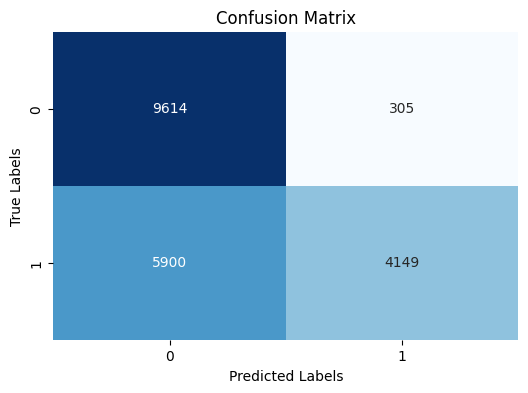

Precision: 0.9315
Recall: 0.4129
F1 Score: 0.5722
ROC-AUC Score: 0.7932


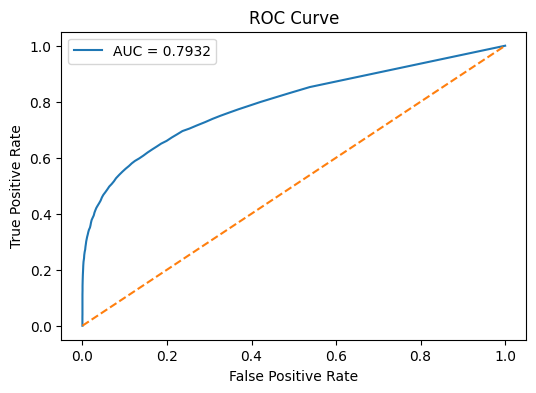

Train Loss avg: 49.8983, 
Test Loss avg: 48.4321
Train Acc: 67.87%, 
Test Acc: 68.93
MSE Train: 0.000000, 
MSE Test: 0.000000

Epoch 2/10

Epoch 2/10 - Evaluation Metrics_Testing:


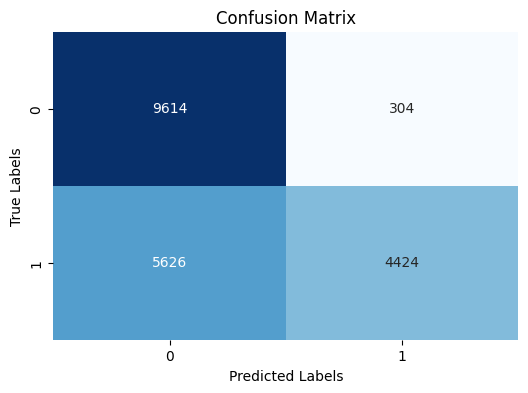

Precision: 0.9357
Recall: 0.4402
F1 Score: 0.5987
ROC-AUC Score: 0.8012


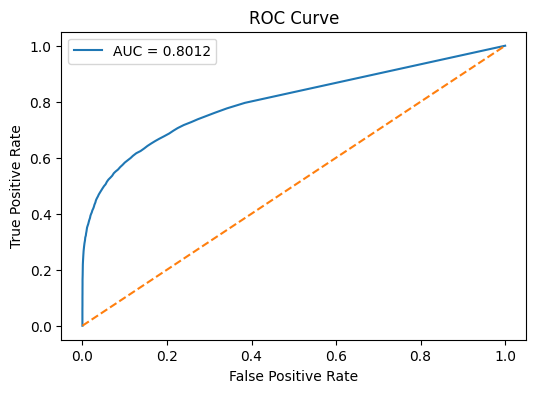

Train Loss avg: 46.5369, 
Test Loss avg: 45.5201
Train Acc: 70.13%, 
Test Acc: 70.30
MSE Train: 0.000000, 
MSE Test: 0.000000

Epoch 3/10

Epoch 3/10 - Evaluation Metrics_Testing:


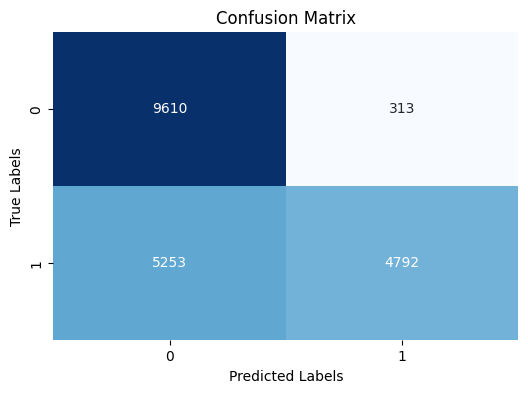

Precision: 0.9387
Recall: 0.4771
F1 Score: 0.6326
ROC-AUC Score: 0.8179


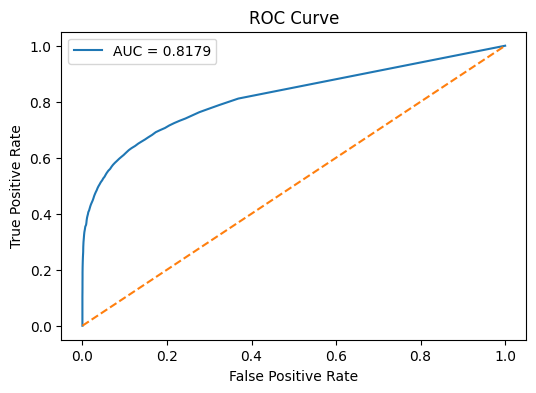

Train Loss avg: 44.4979, 
Test Loss avg: 43.8117
Train Acc: 72.03%, 
Test Acc: 72.13
MSE Train: 0.000000, 
MSE Test: 0.000000

Epoch 4/10

Epoch 4/10 - Evaluation Metrics_Testing:


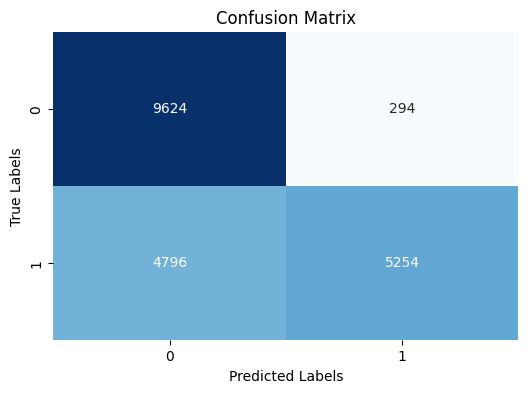

Precision: 0.9470
Recall: 0.5228
F1 Score: 0.6737
ROC-AUC Score: 0.8403


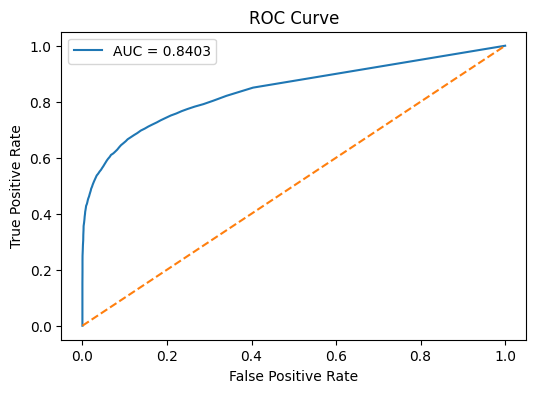

Train Loss avg: 42.8791, 
Test Loss avg: 42.3357
Train Acc: 74.24%, 
Test Acc: 74.51
MSE Train: 0.000000, 
MSE Test: 0.000000

Epoch 5/10

Epoch 5/10 - Evaluation Metrics_Testing:


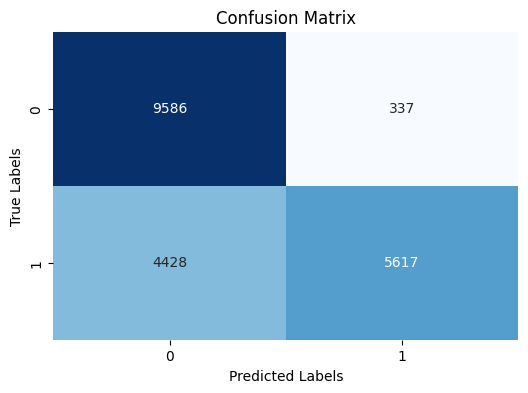

Precision: 0.9434
Recall: 0.5592
F1 Score: 0.7022
ROC-AUC Score: 0.8502


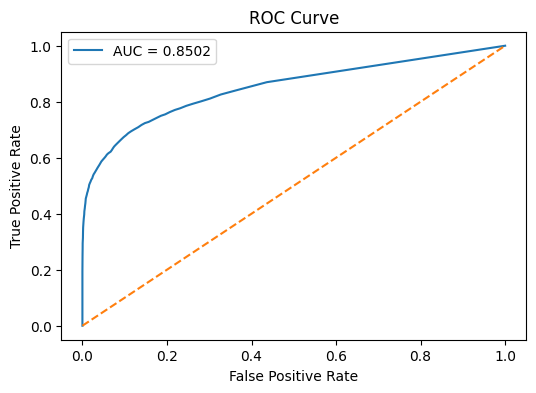

Train Loss avg: 41.6647, 
Test Loss avg: 42.4411
Train Acc: 75.92%, 
Test Acc: 76.14
MSE Train: 0.000000, 
MSE Test: 0.000000

Epoch 6/10

Epoch 6/10 - Evaluation Metrics_Testing:


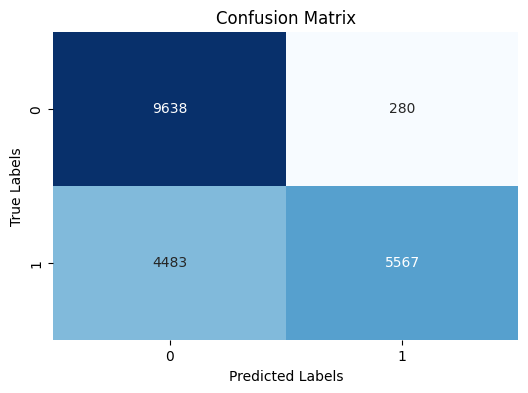

Precision: 0.9521
Recall: 0.5539
F1 Score: 0.7004
ROC-AUC Score: 0.8528


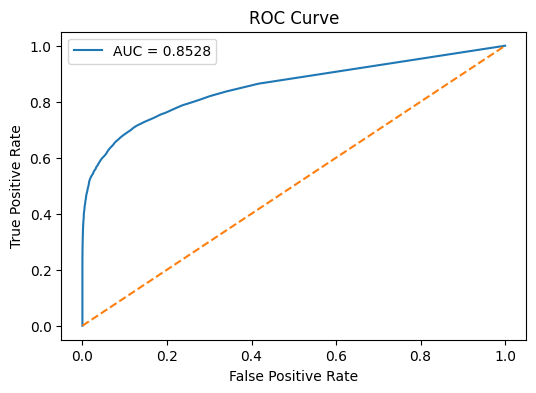

Train Loss avg: 41.1139, 
Test Loss avg: 41.2491
Train Acc: 76.72%, 
Test Acc: 76.15
MSE Train: 0.000000, 
MSE Test: 0.000000

Epoch 7/10

Epoch 7/10 - Evaluation Metrics_Testing:


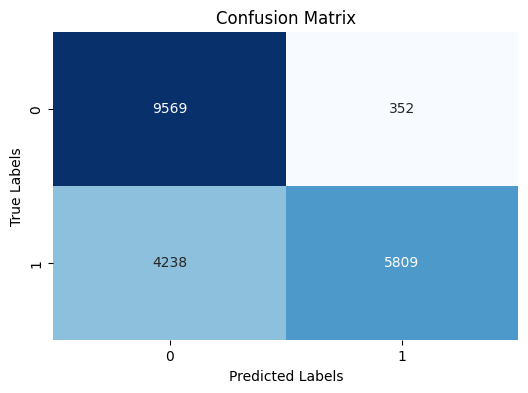

Precision: 0.9429
Recall: 0.5782
F1 Score: 0.7168
ROC-AUC Score: 0.8561


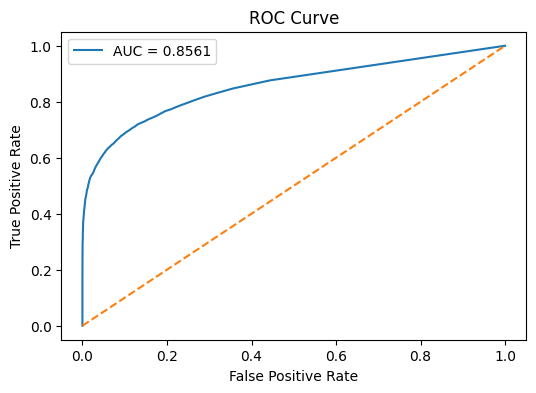

Train Loss avg: 40.6980, 
Test Loss avg: 41.3064
Train Acc: 77.14%, 
Test Acc: 77.01
MSE Train: 0.000000, 
MSE Test: 0.000000

Epoch 8/10

Epoch 8/10 - Evaluation Metrics_Testing:


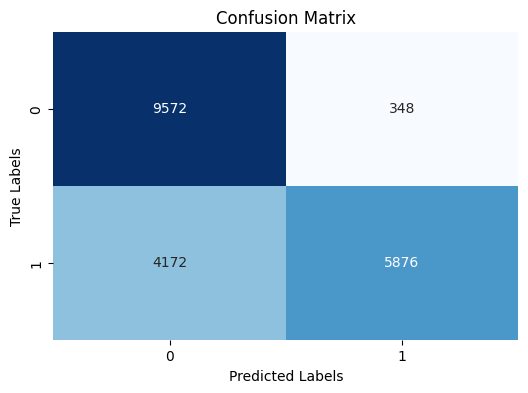

Precision: 0.9441
Recall: 0.5848
F1 Score: 0.7222
ROC-AUC Score: 0.8585


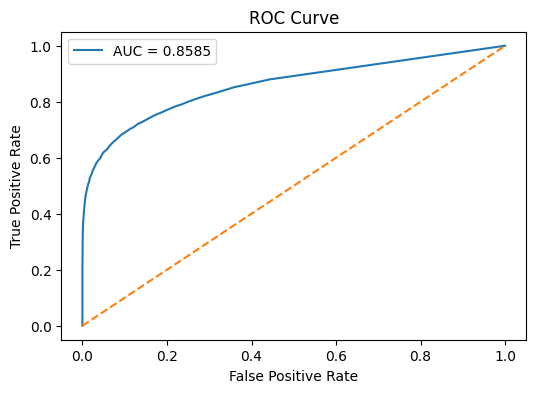

Train Loss avg: 40.4763, 
Test Loss avg: 41.1680
Train Acc: 77.47%, 
Test Acc: 77.36
MSE Train: 0.000000, 
MSE Test: 0.000000

Epoch 9/10

Epoch 9/10 - Evaluation Metrics_Testing:


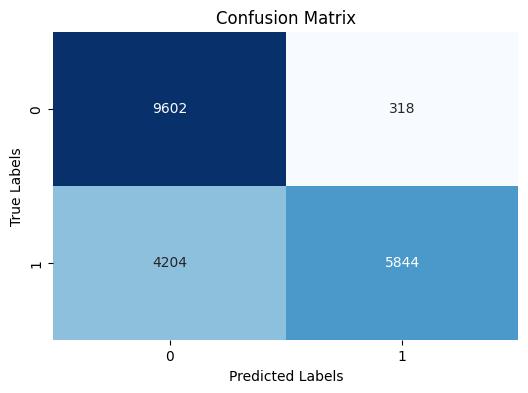

Precision: 0.9484
Recall: 0.5816
F1 Score: 0.7210
ROC-AUC Score: 0.8618


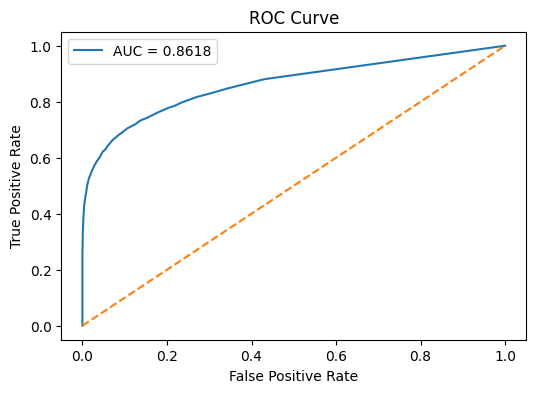

Train Loss avg: 40.3018, 
Test Loss avg: 40.6480
Train Acc: 77.70%, 
Test Acc: 77.35
MSE Train: 0.000000, 
MSE Test: 0.000000

Epoch 10/10

Epoch 10/10 - Evaluation Metrics_Testing:


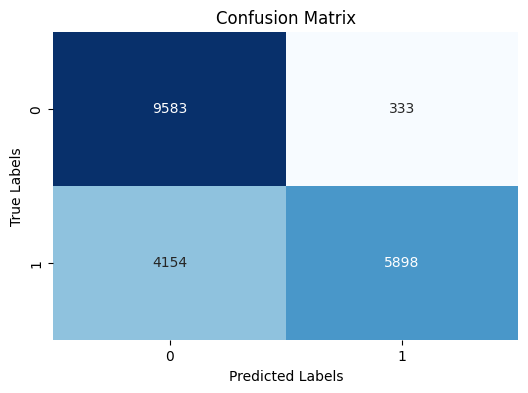

Precision: 0.9466
Recall: 0.5867
F1 Score: 0.7244
ROC-AUC Score: 0.8603


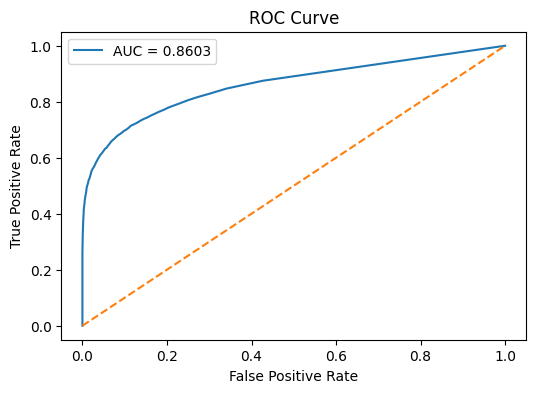

Train Loss avg: 40.0114, 
Test Loss avg: 40.3879
Train Acc: 77.84%, 
Test Acc: 77.53
MSE Train: 0.000000, 
MSE Test: 0.000000
Total time: 113.04 min.


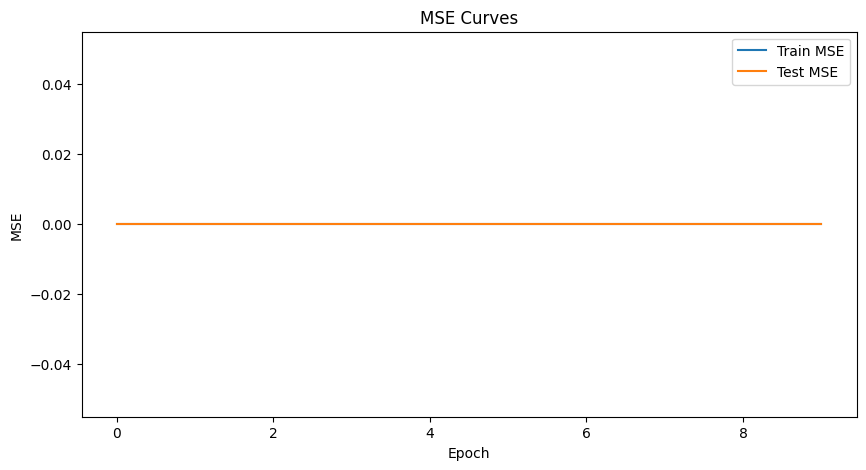

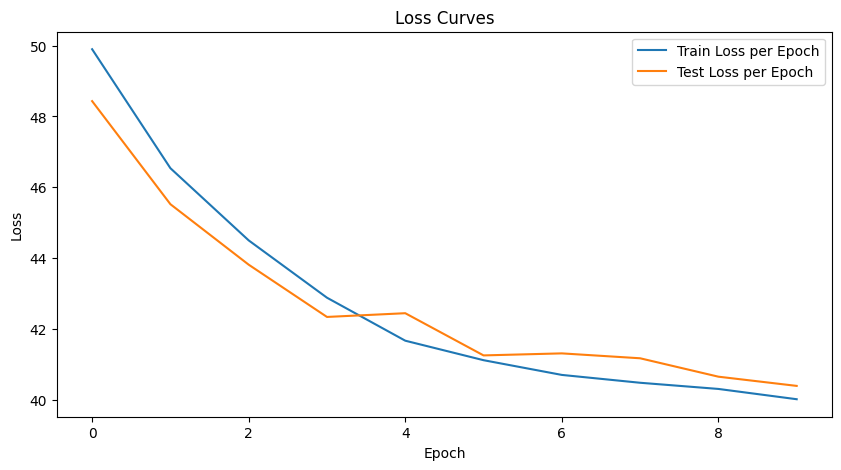

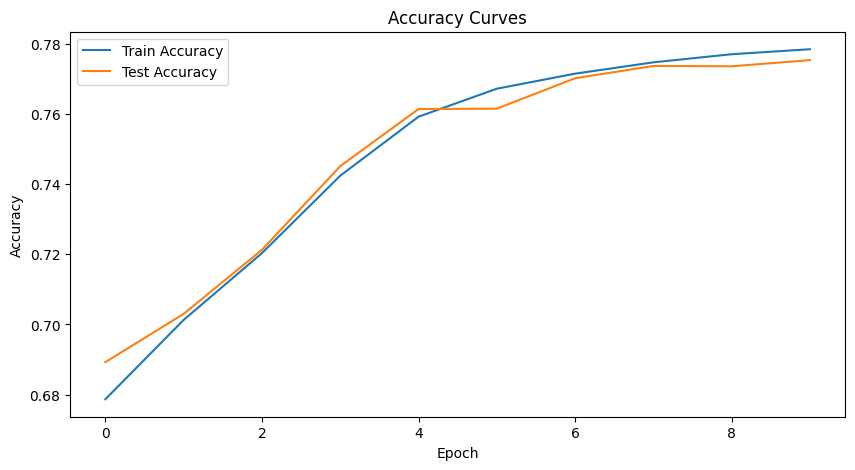

In [ ]:
import time
from snntorch import functional as SF

# Loss functions
loss = nn.BCEWithLogitsLoss()
loss_reg = nn.MSELoss()

# Optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999), weight_decay=1e-4)

# Hyperparameters
tau_scale = 1e9
num_epochs = 10
num_steps = 80

epoch_train_acc = []
epoch_test_acc = []
epoch_train_loss = []
epoch_test_loss = []
epoch_train_mse = []
epoch_test_mse = []

# TRAIN--------------------------------
def train_model(train_loader):
    net.train()
    loss_hist = []
    mse_list = []
    # all_preds = []
    # all_targets = []
    train_acc_hist = []


    train_batch = iter(train_loader)
    for y, x, v in train_batch:
        y = y.to(device).permute(1, 0, 2)
        x = x.to(device).permute(1, 0, 2)
        target_v = v.to(device).float().unsqueeze(1)
        # target_tau = (tau.to(device) * tau_scale).float().unsqueeze(1)

        # Forward Pass
        spk_class, mem_class = net(y, x)  #mem_rec.shape torch.Size([80, 128, 1])

        # Classification Loss
        loss_class = torch.zeros((1), dtype=dtype, device=device)
        for step in range(num_steps):
            loss_class += loss(mem_class[step], target_v)

        # # Regression Loss
        # tau_output = tau_pre.mean(dim=0)
        # loss_reg_val = loss_reg(tau_output, target_tau)


        # Total Loss
        total_loss = loss_class #+ loss_reg_val
        loss_hist.append(total_loss.item())

        # Backpropagation
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        # Metrics
        train_acc, train_mse = print_batch_accuracy(spk_class, target_v, train=True)
        train_acc_hist.append(train_acc)
        mse_list.append(train_mse)

        # # Collect Predictions
        # class_output = spk_class.sum(dim=0)
        # all_preds.extend(class_output.squeeze().cpu().detach().numpy())
        # all_targets.extend(target_v.squeeze().cpu().numpy())

    # # Compute Overall Train Metrics
    # all_preds = torch.tensor(all_preds)
    # all_targets = torch.tensor(all_targets)
    # print(f"\nEpoch {epoch+1}/{num_epochs} - Evaluation Metrics_Training:")
    # calculate_metrics(all_targets, all_preds)

    avg_train_loss = sum(loss_hist) / len(loss_hist)
    avg_train_acc = sum(train_acc_hist) / len(train_acc_hist)
    avg_train_mse = sum(mse_list) / len(mse_list)

    return avg_train_loss, avg_train_acc, avg_train_mse


# TEST------------------------------------------------------
def test_model(test_loader):
    net.eval()
    test_loss_hist = []
    test_mse_list = []
    all_preds = []
    all_targets = []
    test_acc_hist = []

    with torch.no_grad():

        test_batch = iter(test_loader)
        for y, x, v in test_batch:
            y = y.to(device).permute(1, 0, 2)
            x = x.to(device).permute(1, 0, 2)
            target_v = v.to(device).float().unsqueeze(1)
            # target_tau = (tau.to(device) * tau_scale).float().unsqueeze(1)

            # Forward Pass
            spk_class, mem_class = net(y, x)

            # Classification Loss
            test_loss_class = torch.zeros((1), dtype=dtype, device=device)
            for step in range(num_steps):
                test_loss_class += loss(mem_class[step], target_v)

            # # Regression Loss
            # test_tau_output = tau_pre.mean(dim=0)
            # test_loss_reg = loss_reg(test_tau_output, target_tau)
            # # print(f"test_loss_reg_val: {test_loss_reg_val}")tau)

            # Total Test Loss
            test_total_loss = test_loss_class #+ test_loss_reg
            test_loss_hist.append(test_total_loss.item())

            # Compute Metrics
            test_acc, test_mse = print_batch_accuracy(spk_class, target_v, train=False)
            test_acc_hist.append(test_acc)
            test_mse_list.append(test_mse)

            # Collect Predictions
            class_output = spk_class.sum(dim=0)
            all_preds.extend(class_output.squeeze().cpu().numpy())
            all_targets.extend(target_v.squeeze().cpu().numpy())

    # Compute Overall Test Metrics
    all_preds = torch.tensor(all_preds)
    all_targets = torch.tensor(all_targets)
    print(f"\nEpoch {epoch+1}/{num_epochs} - Evaluation Metrics_Testing:")
    calculate_metrics(all_targets, all_preds)

    avg_test_loss = sum(test_loss_hist) / len(test_loss_hist)
    avg_test_acc = sum(test_acc_hist) / len(test_acc_hist)
    avg_test_mse = sum(test_mse_list) / len(test_mse_list)

    return avg_test_loss, avg_test_acc, avg_test_mse


# MAIN TRAINING & TESTING LOOP-----------------------------

start_time = time.time()

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")

    # Train the Model
    avg_train_loss, avg_train_acc, avg_train_mse = train_model(train_loader)
    epoch_train_loss.append(avg_train_loss)
    epoch_train_acc.append(avg_train_acc)
    epoch_train_mse.append(avg_train_mse)

    # Test the Model
    avg_test_loss, avg_test_acc, avg_test_mse = test_model(test_loader)
    epoch_test_loss.append(avg_test_loss)
    epoch_test_acc.append(avg_test_acc)
    epoch_test_mse.append(avg_test_mse)


    print(f"Train Loss avg: {avg_train_loss:.4f}, \nTest Loss avg: {avg_test_loss:.4f}")
    print(f"Train Acc: {avg_train_acc * 100:.2f}%, \nTest Acc: {avg_test_acc * 100:.2f}")
    print(f"MSE Train: {avg_train_mse:.6f}, \nMSE Test: {avg_test_mse:.6f}")


# Plot--------------------------------------------------------
end_time = time.time()
print(f"Total time: {(end_time - start_time) / 60:.2f} min.")

# Plot MSE Loss
plt.figure(figsize=(10, 5))
plt.plot(range(len(epoch_train_mse)), epoch_train_mse, label="Train MSE")
plt.plot(range(len(epoch_test_mse)), epoch_test_mse, label="Test MSE")
plt.title("MSE Curves")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.show()

# Plot Train & Test Loss per Epoch
plt.figure(figsize=(10, 5))
plt.plot(range(len(epoch_train_loss)), epoch_train_loss, label="Train Loss per Epoch")
plt.plot(range(len(epoch_test_loss)), epoch_test_loss, label="Test Loss per Epoch")
plt.title("Loss Curves")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plot Accuracy Curves
plt.figure(figsize=(10, 5))
plt.plot(range(len(epoch_train_acc)), epoch_train_acc, label="Train Accuracy")
plt.plot(range(len(epoch_test_acc)), epoch_test_acc, label="Test Accuracy")
plt.title("Accuracy Curves")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


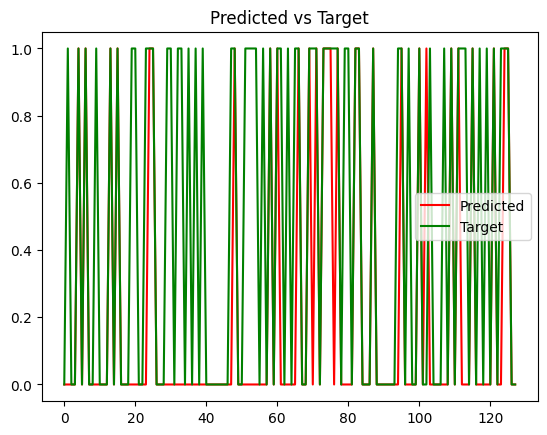

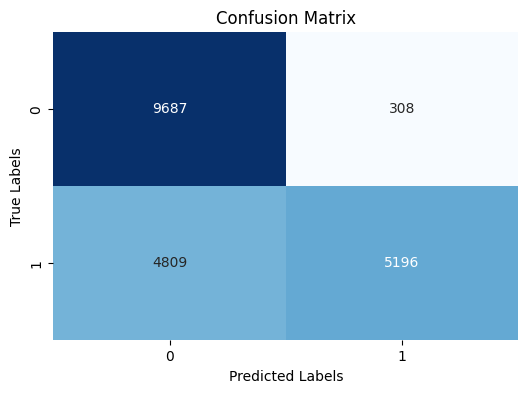

Precision: 0.9440
Recall: 0.5193
F1 Score: 0.6701
ROC-AUC Score: 0.8362


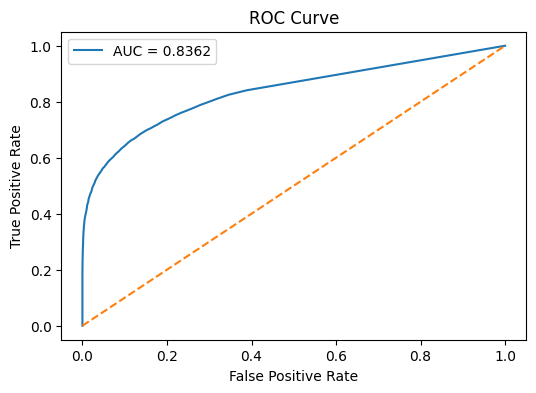

Total size: 20000, Correct_Prediction: 14883.0
Test Set Accuracy: 74.415%, acc : 74.43%
Average Test Loss: 44.1749


In [ ]:
#Test the model with dataset5------------------------------
total = 0
correct = 0
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True, drop_last=False)
total_loss=0
i=0
all_preds=[]
all_targets=[]
accList=[]

with torch.no_grad():
  net.eval()
  for y_t, x_t, target_t in test_loader:
    y_t = y_t.to(device).permute(1, 0, 2)
    x_t = x_t.to(device).permute(1, 0, 2)
    target_t = target_t.to(device)
    targets = target_t.to(device).float().unsqueeze(1)

    test_spk, test_mem = net(y_t, x_t)  # forward pass

    # Calculate loss
    batch_loss = torch.zeros((1), dtype=dtype, device=device)
    for step in range(num_steps):
      batch_loss += loss(test_mem[step], targets)
    total_loss += batch_loss.item()

    # Calculate accuracy
    predicted = (test_spk.sum(dim=0) > num_steps / 2).float()
    acc = (predicted == targets).float().mean().item()
    correct += (predicted == targets).float().sum().item()
    total += targets.size(0)

    classOutput = test_spk.sum(dim=0)
    all_preds.extend(classOutput.squeeze().cpu().numpy())
    all_targets.extend(targets.squeeze().cpu().numpy())

    accList.append(acc)

    i+=1
    if i == 1:
      plt.plot(predicted, label='Predicted', color='red')
      plt.plot(targets, label='Target', color='green')
      plt.title('Predicted vs Target')
      plt.legend()
      plt.show()

# Compute Overall Test Metrics
all_preds = torch.tensor(all_preds)
all_targets = torch.tensor(all_targets)
calculate_metrics(all_targets, all_preds)


print(f"Total size: {total}, Correct_Prediction: {correct}")
print(f"Test Set Accuracy: {100 * correct / total}%, acc : {(sum(accList)/ len(accList)) * 100:.2f}%")
print(f"Average Test Loss: {total_loss / len(test_loader):.4f}")



